# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import PIL.Image
import torchvision
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [ ]:
# import os
# import numpy as np
# import PIL.Image
# import torch
# import torchvision.transforms as transforms

# # Assuming 'segmentation_module' is a pre-loaded semantic segmentation model
# # segmentation_module = ...

# # Define the path to your images
# folder_path = '/content/drive/My Drive/Colab Notebooks/Data/PaipaSVI/try'

# # List all jpg files in the directory
# image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# # Check if there are any image files
# if not image_files:
#     raise ValueError("No image files found in the specified directory.")

# # Define the image loading and transformation steps
# pil_to_tensor = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Loop through each image file
# for image_file in image_files:
#     # Complete path to the image
#     image_path = os.path.join(folder_path, image_file)

#     # Load the image and convert to RGB
#     pil_image = PIL.Image.open(image_path).convert('RGB')
#     img_original = np.array(pil_image)

#     # Transform the image to a tensor
#     img_data = pil_to_tensor(pil_image)

#     # Create a singleton batch for the image data. If using CUDA, move to GPU
#     singleton_batch = {'img_data': img_data.unsqueeze(0).cuda()} if torch.cuda.is_available() else {'img_data': img_data.unsqueeze(0)}

#     # Output size
#     output_size = img_data.shape[1:]

#     # Run the segmentation model on the batch
#     with torch.no_grad():
#         scores = segmentation_module(singleton_batch, segSize=output_size)

#     # Get the predicted scores for each pixel
#     _, pred = torch.max(scores, dim=1)
#     pred = pred.cpu().numpy()  # Assuming you're using CUDA, move the predictions back to CPU

#     # Optionally, visualize the result or process it further
#     # visualize_result(img_original, pred[0])

#     # ... (Any additional post-processing code)

#     # If you need to print the file name and output size
#     print(f"Processed image file: {image_file}")
#     print(f"Output size: {output_size}")


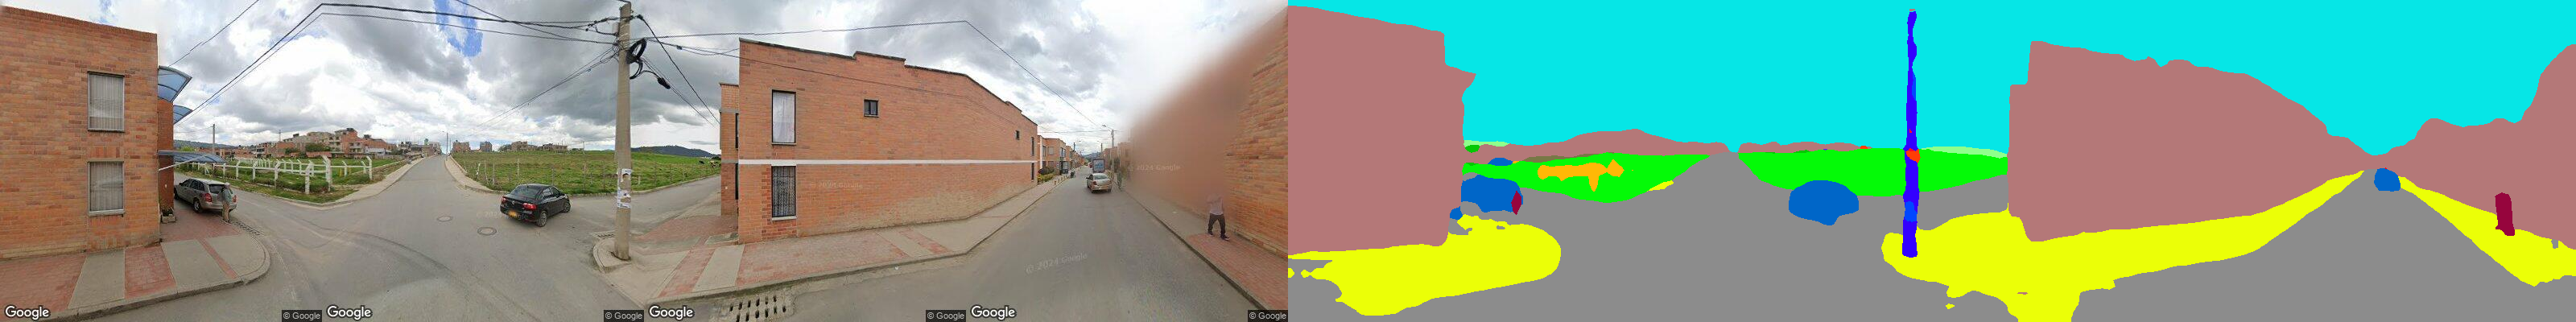

In [ ]:
# visualize_result(img_original, pred[0])

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

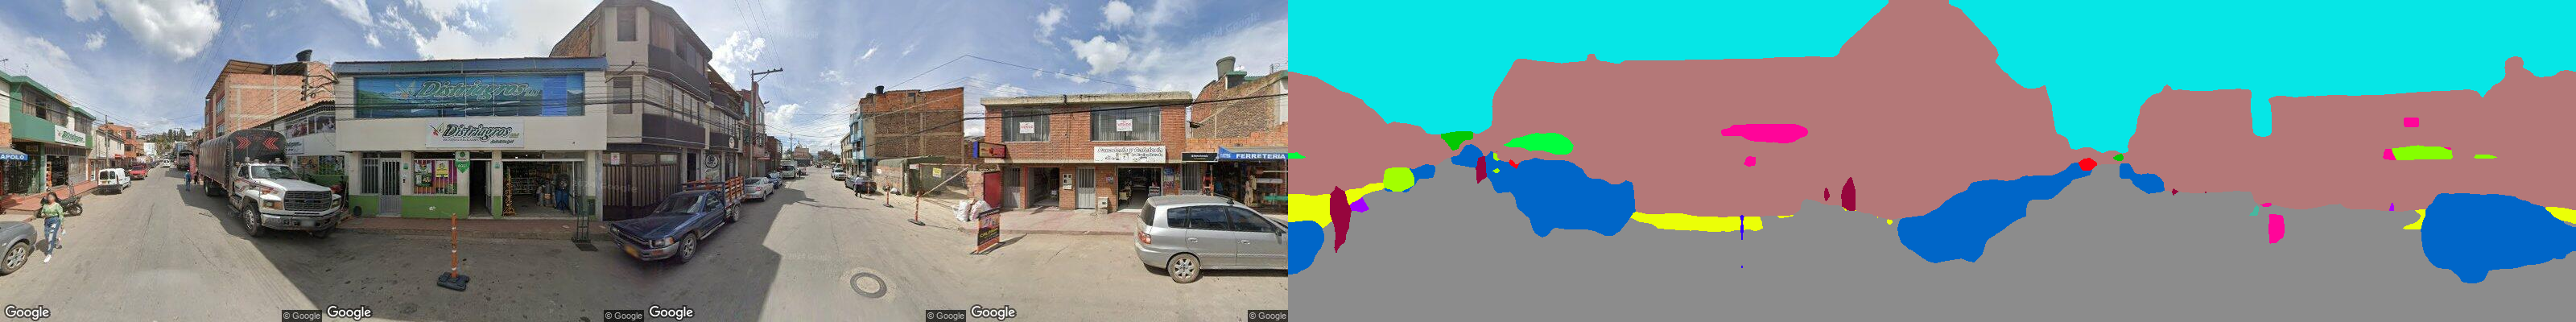

In [ ]:
# # Run the segmentation at the highest resolution.
# with torch.no_grad():
#     scores = segmentation_module(singleton_batch, segSize=output_size)

# # Get the predicted scores for each pixel
# _, pred = torch.max(scores, dim=1)
# pred = pred.cpu()[0].numpy()
# visualize_result(img_original, pred)

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Data/perceptions_export/'
files = [f for f in os.listdir(folder_path) if f.startswith('final') and f.endswith('.csv')]

dataframes = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df = df.drop(['POINT_X', 'POINT_Y'], axis = 1, errors='ignore')
    df.rename(columns={'Q_pred': file}, inplace=True)
    dataframes.append(df)
dataframes[1]


,final_livelier.csv,OID_
0,-1.0,5205
1,-1.0,5206
2,-1.0,5207
3,-1.0,5208
4,-1.0,5209
...,...,...
15245,-1.0,16954
15246,-1.0,16955
15247,-1.0,16972
15248,-1.0,16970


In [ ]:
# 使用pd.concat()将所有DataFrame连接起来，假设'on'参数为共同的列名
combined_df = pd.concat(dataframes,  axis = 1)
combined_df = combined_df.T.drop_duplicates().T
combined_df.rename(columns={'OID_': 'image_id'}, inplace=True)
combined_df['image_id'] = combined_df['image_id'].fillna('').astype(str) + '_panorama.jpg'
dfs = [combined_df[i:i+100] for i in range(0, len(combined_df), 100)]
dfs[111]

,final_safer.csv,image_id,POINT_X_x,POINT_Y_x,final_livelier.csv,final_wealthier.csv,final_beautiful.csv,final_boring.csv,final_depressing.csv
11100,-1.0,12628.0_panorama.jpg,-73.108697,5.776370,-1.0,-1.0,1.0,1.0,1.0
11101,-1.0,12641.0_panorama.jpg,-73.108871,5.775267,-1.0,-1.0,-1.0,1.0,1.0
11102,-1.0,12645.0_panorama.jpg,-73.123062,5.784651,-1.0,-1.0,-1.0,1.0,1.0
11103,-1.0,12644.0_panorama.jpg,-73.123129,5.784701,-1.0,-1.0,-1.0,1.0,1.0
11104,-1.0,12578.0_panorama.jpg,-73.105964,5.775391,-1.0,-1.0,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...
11195,-1.0,12704.0_panorama.jpg,-73.121437,5.774625,-1.0,-1.0,-1.0,1.0,1.0
11196,-1.0,12705.0_panorama.jpg,-73.121352,5.774648,-1.0,-1.0,-1.0,1.0,1.0
11197,-1.0,12718.0_panorama.jpg,-73.123157,5.775000,-1.0,-1.0,-1.0,1.0,1.0
11198,-1.0,12697.0_panorama.jpg,-73.122011,5.774485,-1.0,-1.0,-1.0,1.0,1.0


In [ ]:
classes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/Semantic_Segmentation/color_coding_classes.csv')
classes = classes.dropna(axis='columns', how='all')

In [ ]:
classes

,Idx,Ratio,Train,Val,Stuff,"Color_Code (R,G,B)",Color_Code(hex),Name
0,1,0.1576,11664,1172,1,"(120, 120, 120)",#787878,wall
1,2,0.1072,6046,612,1,"(180, 120, 120)",#B47878,building;edifice
2,3,0.0878,8265,796,1,"(6, 230, 230)",#06E6E6,sky
3,4,0.0621,9336,917,1,"(80, 50, 50)",#503232,floor;flooring
4,5,0.0480,6678,641,0,"(4, 200, 3)",#04C803,tree
...,...,...,...,...,...,...,...,...
145,146,0.0003,130,14,0,"(0, 133, 255)",#0085FF,shower
146,147,0.0003,178,28,0,"(255, 214, 0)",#FFD600,radiator
147,148,0.0002,504,57,0,"(25, 194, 194)",#19C2C2,glass;drinking;glass
148,149,0.0002,775,96,0,"(102, 255, 0)",#66FF00,clock


In [ ]:
import os
import PIL.Image
import numpy as np
import torchvision.transforms as transforms
import torch

# Ensure the segmentation module is defined and loaded with the appropriate weights
# segmentation_module = ...

# Define the path to your images
folder_path = '/content/drive/My Drive/Colab Notebooks/Data/PaipaSVI/all'

# List all jpg files in the directory
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Check if there are any image files
if not image_files:
    raise ValueError("No image files found in the specified directory.")

# Define the image loading and transformation steps
pil_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Loop through each image file
i = 0
for dfj in dfs:
    i += 1
    if i == 45 or i == 110:
        image_files = dfj['image_id'].tolist()
        pred_list = []
        for image_file in image_files:
            # Complete path to the image
            image_path = os.path.join(folder_path, image_file)
            # Load the image and convert to RGB
            pil_image = PIL.Image.open(image_path).convert('RGB')
            img_original = np.array(pil_image)
            # Transform the image to tensor
            img_data = pil_to_tensor(pil_image)

            # Create a singleton batch for the image data
            # singleton_batch = {'img_data': img_data[None]}  # Use .cuda() if you are using CUDA
            singleton_batch = {'img_data': img_data.unsqueeze(0).cuda()} if torch.cuda.is_available() else {'img_data': img_data.unsqueeze(0)}
            # Output size
            output_size = img_data.shape[1:]

            # Run the segmentation at the highest resolution
            with torch.no_grad():
                scores = segmentation_module(singleton_batch, segSize=output_size)

            # Get the predicted scores for each pixel
            _, pred = torch.max(scores, dim=1)
            pred = pred.cpu().numpy()
            pred_list.append(pred)
            # Visualize and/or process the result
            # Assuming visualize_result is a function you have defined for visualization
            #visualize_result(img_original, pred[0])

            # Additional processing (e.g., calculate proportions) can be done here if needed
        # Create a dictionary to map from class index to class name
        class_index_to_name = pd.Series(classes.Name.values,index=classes.Idx).to_dict()
        # Initialize a list to store the proportion data for each image
        image_class= []
        for pred in pred_list:
            # Flatten the prediction array to a one-dimensional array
            pred_flat = pred.flatten()

            # Count the occurrences of each unique class index
            unique, counts = np.unique(pred_flat, return_counts=True)

            # Step 3: Calculate the proportions
            proportions = counts / pred_flat.size

            # Step 4: Map the indices to class names and create a dictionary
            # class_proportions = {class_index_to_name.get(idx, 'Unknown'): prop for idx, prop in zip(unique, proportions)}
            class_proportions = {label: proportion for label, proportion in zip(unique, proportions)}
            # Add the dictionary to our list
            image_class.append(class_proportions)

        class_proportions_df = pd.DataFrame(image_class)

        # Replace NaN with zeros if any class is not present in an image
        class_proportions_df.fillna(0, inplace=True)

        # Now `class_proportions_df` is the desired DataFrame
        # Each row represents an image and each column represents the proportion of a class
        class_proportions_df.insert(0, 'image_id', image_files)
        class_proportions_df = pd.merge(class_proportions_df, dfj, on = 'image_id')

        class_proportions_df.to_csv(f'/content/drive/My Drive/Colab Notebooks/Data/Semantic_Segmentation/plus_all/{i}.csv')

        # Note: This code assumes you're working in an environment with PyTorch and your segmentation model loaded.


In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Data/Semantic_Segmentation/plus_all'
save_path = '/content/drive/My Drive/Colab Notebooks/Data/Semantic_Segmentation'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dataframes = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_csv_path = os.path.join(save_path, 'semantic_result.csv')
combined_df.to_csv(combined_csv_path, index=False)


In [ ]:
combined_df

,Unnamed: 0,image_id,1,2,4,6,9,11,12,16,...,137,96,85,62,33,129,133,124,73,101
0,0,5205.0_panorama.jpg,0.022014,0.444005,0.041223,0.341505,0.133877,0.000597,0.000259,0.005775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5206.0_panorama.jpg,0.018830,0.444069,0.044503,0.278747,0.190036,0.006427,0.000037,0.003723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5207.0_panorama.jpg,0.021781,0.443564,0.043369,0.296600,0.177828,0.002853,0.000000,0.002256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5208.0_panorama.jpg,0.025619,0.442730,0.041752,0.323264,0.152892,0.000539,0.000008,0.003986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5209.0_panorama.jpg,0.016856,0.440219,0.047219,0.355034,0.121405,0.000000,0.000283,0.003609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15245,95,12473.0_panorama.jpg,0.000141,0.274066,0.236536,0.026244,0.333022,0.000000,0.000000,0.002580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15246,96,12474.0_panorama.jpg,0.000000,0.311864,0.203027,0.037487,0.353225,0.000000,0.000077,0.002181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15247,97,12475.0_panorama.jpg,0.000009,0.299355,0.216672,0.035747,0.355856,0.000000,0.001139,0.002255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15248,98,12476.0_panorama.jpg,0.000050,0.401772,0.104838,0.051544,0.362150,0.000000,0.002086,0.003205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# import pandas as pd
# import numpy as np


# # Create a dictionary to map from class index to class name
# class_index_to_name = pd.Series(classes.Name.values,index=classes.Idx).to_dict()

# # Initialize a list to store the proportion data for each image
# image_class= []

# # Step 2: Assume you have a list of prediction results for each image
# # pred_list = [pred1, pred2, ...] # These would be numpy arrays

# for pred in pred_list:
#     # Flatten the prediction array to a one-dimensional array
#     pred_flat = pred.flatten()

#     # Count the occurrences of each unique class index
#     unique, counts = np.unique(pred_flat, return_counts=True)

#     # Step 3: Calculate the proportions
#     proportions = counts / pred_flat.size

#     # Step 4: Map the indices to class names and create a dictionary
#     # class_proportions = {class_index_to_name.get(idx, 'Unknown'): prop for idx, prop in zip(unique, proportions)}
#     class_proportions = {label: proportion for label, proportion in zip(unique, proportions)}
#     # Add the dictionary to our list
#     image_class.append(class_proportions)



In [ ]:
# # Step 5: Create a DataFrame from the list of dictionaries

# class_proportions_df = pd.DataFrame(image_class)

# # Replace NaN with zeros if any class is not present in an image
# class_proportions_df.fillna(0, inplace=True)

# # Now `class_proportions_df` is the desired DataFrame
# # Each row represents an image and each column represents the proportion of a class
# class_proportions_df.insert(0, 'ID', ids)
# class_proportions_df

,ID,0,1,2,4,6,9,12,16,20,...,39,69,112,5,18,123,92,76,115,136
0,14712,0.003567,0.016856,0.440219,0.047219,0.355034,0.121405,0.000283,0.003609,0.001472,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,14587,0.000252,0.028897,0.441098,0.029106,0.346527,0.090861,0.000000,0.006313,0.027917,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,15086,0.001659,0.194992,0.346831,0.000023,0.350011,0.003434,0.002295,0.000161,0.004370,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,15304,0.000003,0.131116,0.389172,0.011211,0.311038,0.012511,0.015003,0.000995,0.028092,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,13640,0.000000,0.143447,0.385517,0.027406,0.344833,0.055130,0.000000,0.000620,0.003775,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5,14503,0.001973,0.021687,0.374745,0.054286,0.209780,0.217784,0.000000,0.000727,0.000284,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,14588,0.000013,0.091281,0.406537,0.008438,0.307919,0.025742,0.000000,0.003445,0.037172,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
7,14560,0.000000,0.147425,0.373211,0.000000,0.354650,0.008481,0.003472,0.004123,0.021997,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
8,14105,0.000572,0.242823,0.347142,0.003662,0.237347,0.000708,0.000000,0.000656,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9,15471,0.000497,0.026469,0.436884,0.034953,0.420450,0.051581,0.001027,0.002338,0.010086,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# import torch

# # Assuming 'pred' is the output of your segmentation model
# # Flatten the prediction to a one-dimensional array
# pred_flat = pred.flatten()

# # Count the occurrences of each unique label
# unique, counts = np.unique(pred_flat, return_counts=True)

# # Calculate the total number of pixels
# total_pixels = pred_flat.size

# # Calculate the proportion of each label
# proportions = counts / total_pixels

# # Create a dictionary to hold the label-proportion mappings
# label_proportions = {label: proportion for label, proportion in zip(unique, proportions)}

# print(label_proportions)


## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

In [ ]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_result(img_original, pred, c)

Output hidden; open in https://colab.research.google.com to view.